In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np # to use numpy arrays instead of lists
import pandas as pd # DataFrame (table)
import matplotlib.pyplot as plt
import math

In [2]:
from sklearn.model_selection import train_test_split
import sklearn.decomposition as sk # to compute PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
def leeDatos():

    dataSet = pd.read_csv("covid.csv", header=0, index_col=0)
    dataSet.index = pd.to_datetime(dataSet.index,format='%d/%m/%y',errors='ignore')

    return dataSet

def graficaDatos(dataSet=0):

    plt.figure()
    for i in range(len(dataSet.columns)):
        plt.plot(dataSet.iloc[:,i],label=dataSet.columns[i],marker=i+2,markevery=150)
    plt.grid(color='b',linestyle='dashed')
    plt.gcf().autofmt_xdate()
    plt.title('COVID-19', fontweight='bold')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.legend(loc='upper left')
    plt.show()

def linealizar(dataSet=0):
    """
    Normalize and smooth data
    """
    dataSet = dataSet.fillna(method='ffill')
    #dataSet = dataSet.dropna()

    # computing range of data for the regressions
    size = len(dataSet)
    x = range(size)
    numFeatures = len(dataSet.columns)

    for i in range(numFeatures):
        dataSet.iloc[:,i] = dataSet.iloc[:,i]  / dataSet.iloc[:,i].abs().max()
        polyCoef = np.polyfit(x, dataSet.iloc[:,i], 3)   # coefficients 10
        regModel = np.poly1d(polyCoef)              # equation
        regSpace = np.linspace(1, size, size)          # generate n numbers between a range
        dataSet.iloc[:,i] = regModel(regSpace)

    return dataSet


# --------------------
# split data
def splitDataSet(dataSet=0, test_size=.2, randSplit=True):
    """
    Split data in train and test sets
    """

    train, test = train_test_split(dataSet, test_size=test_size, shuffle=randSplit)

    return [train, test]

# ML methods

In [4]:
def metodosML(dataSet=0, dataSet2=0):

    methodsUsed=['DT', 'RF']
    performanceHeaders=['RSS','SSR','TSS','R-Square','Adj. R-Square']
    comperrHeaders=['MSE','RMSE', 'MAPE']
    errorHeaders=['Mean','Median', 'SD','25%','50%','75%','Min','Max','Range']
    modPerformance = pd.DataFrame(index=methodsUsed, columns=performanceHeaders)
    modPerformance.index.name = "Model Performance"
    comperr = pd.DataFrame(index=methodsUsed, columns=comperrHeaders)
    comperr.index.name = "Error Metrics"
    regError = pd.DataFrame(index=methodsUsed, columns=errorHeaders)
    regError.index.name = "Relative Error"
    modPerformance3 = pd.DataFrame(index=methodsUsed, columns=performanceHeaders)
    modPerformance3.index.name = "Model Performance"
    comperr3 = pd.DataFrame(index=methodsUsed, columns=comperrHeaders)
    comperr3.index.name = "Error Metrics"
    regError3 = pd.DataFrame(index=methodsUsed, columns=errorHeaders)
    regError3.index.name = "Relative Error"

    trainModel = pd.DataFrame()
    testModel = pd.DataFrame()
    yModel = pd.DataFrame()
    yModel3 = pd.DataFrame()
    trainModel['Raw Data'] = dataSet.iloc[:,0]
    testModel['Raw Data'] = dataSet2.iloc[:,0]
    sizeData=len(dataSet.columns)-1

    regr = DecisionTreeRegressor(max_depth=4)
    regr.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))
    # train data
    trainModel['Fitted DT'] = regr.predict(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData))
    yModel['Fitted DT'] = trainModel['Fitted DT']
    # compute residuals, relative error and model performance
    yModel, regError, comperr, modPerformance = compareMethod(yModel, 'DT', dataSet, 0, regError, comperr, modPerformance, 0)
    # test data
    testModel['Fitted DT'] = regr.predict(dataSet2.iloc[:,1:].to_numpy().reshape(len(dataSet2),sizeData))
    yModel3['Fitted DT'] = testModel['Fitted DT']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'DT', dataSet2, 0, regError3, comperr3, modPerformance3, 0)

    # Random Forest
    regr = RandomForestRegressor(n_estimators=4)
    regr.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))
    # train data
    trainModel['Fitted RT'] = regr.predict(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData))
    yModel['Fitted RT'] = trainModel['Fitted RT']
    # compute residuals, relative error and model performance
    yModel, regError, comperr, modPerformance = compareMethod(yModel, 'RT', dataSet, 0, regError, comperr, modPerformance, 1)
    # test data
    testModel['Fitted RT'] = regr.predict(dataSet2.iloc[:,1:].to_numpy().reshape(len(dataSet2),sizeData))
    yModel3['Fitted RT'] = testModel['Fitted RT']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'RT', dataSet2, 0, regError3, comperr3, modPerformance3, 1)
    print("aqui")
    print("Estimated Parameters:")
    print(f"Number of trees (n_estimators): {regr.n_estimators}")
    print(f"Max depth of trees (max_depth): {regr.max_depth}")

    print("=======================================================================")
    print("                      MODEL PERFORMANCE COMPARISON")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(modPerformance.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print("-----------------------------------------------------------------------")
    print(modPerformance3.T)
    print("=======================================================================")
    print("                      ERROR METRICS")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(comperr.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print(comperr3.T)
    print("=======================================================================")
    print("                      MAPE (RELATIVE ERROR) COMPARISON")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(regError.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print("-----------------------------------------------------------------------")
    print(regError3.T)
    print("\n")


    return [trainModel, testModel]

In [5]:
# --------------------
# create performance tables
def compareMethod(yModel, method, dataSet, y, regError, comperr, modPerformance, i):
    name_fit = 'Fitted ' + method
    name_res = 'Residuals ' + method
    name_err = 'Rel Error_' + method

    size = len(yModel)

    # compute residuals and relative error
    yModel[name_res] = dataSet.iloc[:,y] - yModel[name_fit]
    yModel[name_err] = (1-(yModel[name_fit]/dataSet.iloc[:,y])).abs()
    regError.iloc[i,0] = yModel[name_err].mean(axis=0)
    regError.iloc[i,1] = yModel[name_err].median(axis=0)
    regError.iloc[i,2] = yModel[name_err].std(axis=0)
    regError.iloc[i,3] = yModel[name_err].quantile(q=.25)
    regError.iloc[i,4] = yModel[name_err].quantile(q=.5)
    regError.iloc[i,5] = yModel[name_err].quantile(q=.75)
    regError.iloc[i,6] = yModel[name_err].min()
    regError.iloc[i,7] = yModel[name_err].max()
    regError.iloc[i,8] = regError.iloc[i,7] - regError.iloc[i,6]

    # Models Performance
    modPerformance.iloc[i,0] = (yModel[name_res]**2).sum()
    modPerformance.iloc[i,1] = ((yModel[name_fit]-dataSet.iloc[:,y].mean(axis=0))**2).sum()
    modPerformance.iloc[i,2] = modPerformance.iloc[i,0]+modPerformance.iloc[i,1]
    modPerformance.iloc[i,3] = 1-modPerformance.iloc[i,0]/modPerformance.iloc[i,2]
    modPerformance.iloc[i,4] = 1-(1-modPerformance.iloc[i,3])*((size-1)/(size-4-1))

    # error metrics
    comperr.iloc[i,0] = modPerformance.iloc[i,0]/size
    comperr.iloc[i,1] = comperr.iloc[i,0]**(1/2)
    comperr.iloc[i,2] = regError.iloc[i,0]

    return (yModel, regError, comperr, modPerformance)

            AGUASCALIENTES  BAJA CALIFORNIA  BAJA CALIFORNIA SUR  CAMPECHE  \
date                                                                         
2020-02-26               0                0                    0         0   
2020-02-27               0                0                    0         0   
2020-02-28               0                0                    0         0   
2020-02-29               0                0                    0         0   
2020-03-01               0                0                    0         0   
...                    ...              ...                  ...       ...   
2023-06-20               3               27                    2         3   
2023-06-21               2               24                    6         2   
2023-06-22               5               19                    2         0   
2023-06-23               0                6                    3         7   
2023-06-24               0                0                    0

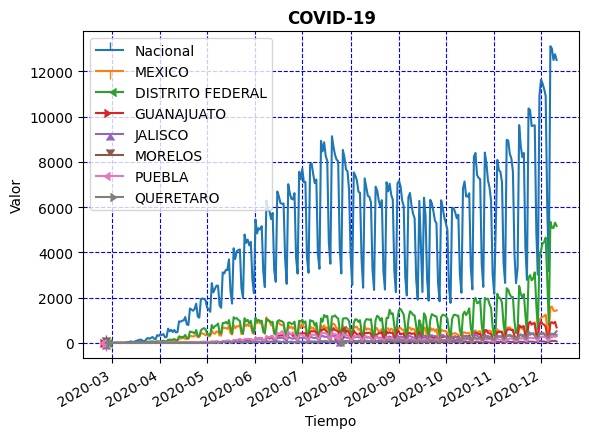

In [6]:
datos = leeDatos()
print(datos)

estados = ['Nacional', 'MEXICO', 'DISTRITO FEDERAL', 'GUANAJUATO', 'JALISCO', 'MORELOS','PUEBLA','QUERETARO']
misDatos = datos[estados]
print(datos[estados])

graficaDatos(misDatos.iloc[0:290,:])

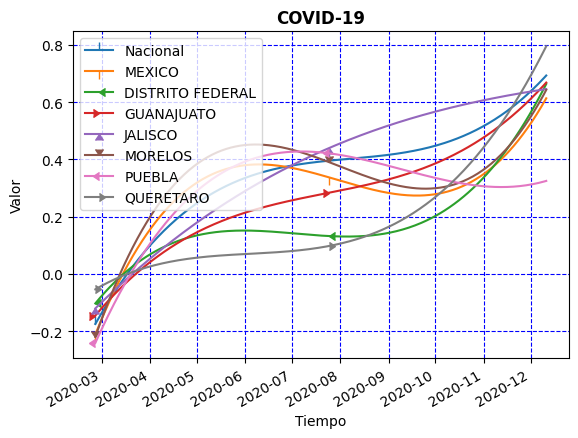

In [7]:
datosLin = linealizar(misDatos.iloc[0:290,:])

graficaDatos(datosLin)

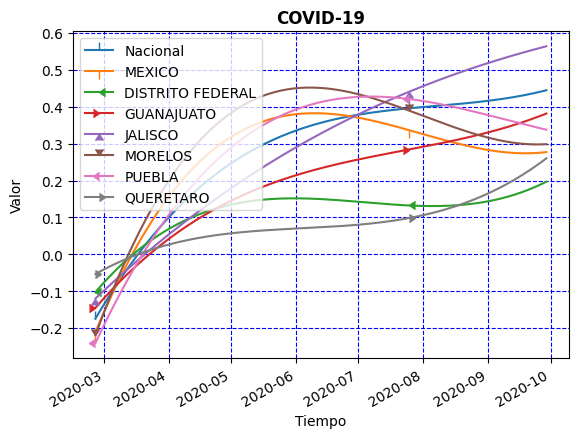

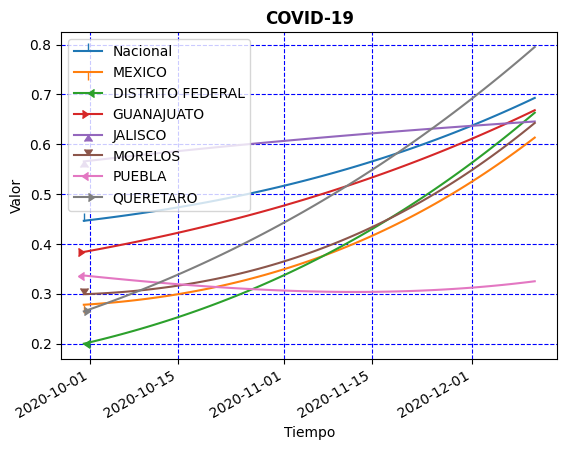

In [8]:
ts_size = .25
[trainSet, testSet] = splitDataSet(datosLin, test_size=ts_size, randSplit=False)

graficaDatos(trainSet)
graficaDatos(testSet)

aqui
Estimated Parameters:
Number of trees (n_estimators): 4
Max depth of trees (max_depth): None
                      MODEL PERFORMANCE COMPARISON
-----------------------------------------------------------------------
                      Training
-----------------------------------------------------------------------
Model Performance        DT        RF
RSS                0.020885  0.000469
SSR                5.700755  5.684594
TSS                5.721639  5.685063
R-Square            0.99635  0.999918
Adj. R-Square      0.996281  0.999916
-----------------------------------------------------------------------
                      Testing
-----------------------------------------------------------------------
Model Performance        DT        RF
RSS                1.325824  1.477023
SSR                0.947289  1.009472
TSS                2.273113  2.486495
R-Square           0.416737  0.405982
Adj. R-Square      0.382427   0.37104
                      ERROR METRICS
----------

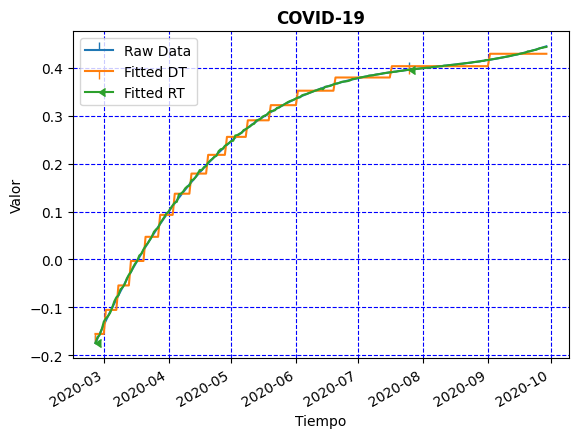

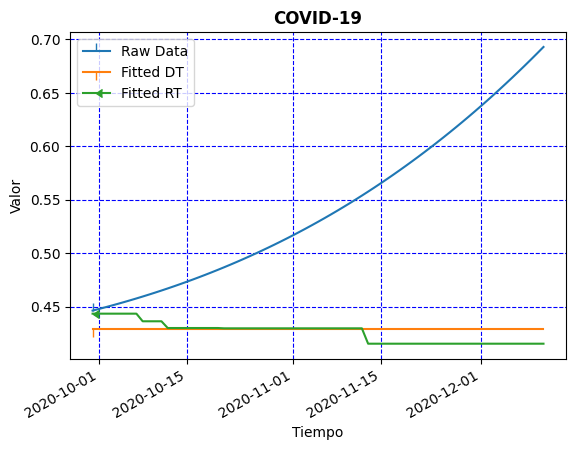

In [9]:
[trainModel, testModel] = metodosML(trainSet, testSet)

graficaDatos(trainModel)
graficaDatos(testModel)